In [1]:
import plotly.io as pio
pio.renderers.default = 'browser'



In [6]:
import json
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go


CATEGORIES = ["Writing", "Roleplay", "Reasoning", "Math", "Coding", "Extraction", "STEM", "Humanities"]


def get_model_df(path):
    cnt = 0
    q2result = []
    fin = open(path, "r")
    for line in fin:
        obj = json.loads(line)
        obj["category"] = CATEGORIES[(obj["question_id"]-81)//10]
        q2result.append(obj)
    df = pd.DataFrame(q2result)
    return df

def toggle(res_str):
    if res_str == "win":
        return "loss"
    elif res_str == "loss":
        return "win"
    return "tie"

def get_model_df_pair():
    fin = open("gpt-4_pair.jsonl", "r")
    cnt = 0
    q2result = []
    for line in fin:
        obj = json.loads(line)

        result = {}
        result["qid"] = str(obj["question_id"])
        result["turn"] = str(obj["turn"])
        if obj["g1_winner"] == "model_1" and obj["g2_winner"] == "model_1":
            result["result"] = "win"
        elif obj["g1_winner"] == "model_2" and obj["g2_winner"] == "model_2":
            result["result"] = "loss"
        else:
            result["result"] = "tie"
        result["category"] = CATEGORIES[(obj["question_id"]-81)//10]
        result["model"] = obj["model_1"]
        q2result.append(result)

    df = pd.DataFrame(q2result)

    return df

df = get_model_df("data\mt_bench\model_judgment\gpt-4_single.jsonl")
# df_pair = get_model_df_pair()

In [7]:
all_models = df["model"].unique()
print(all_models)
scores_all = []
for model in all_models:
    for cat in CATEGORIES:
        # filter category/model, and score format error (<1% case)
        res = df[(df["category"]==cat) & (df["model"]==model) & (df["score"] >= 0)]
        score = res["score"].mean()

        # # pairwise result
        # res_pair = df_pair[(df_pair["category"]==cat) & (df_pair["model"]==model)]["result"].value_counts()
        # wincnt = res_pair["win"] if "win" in res_pair.index else 0
        # tiecnt = res_pair["tie"] if "tie" in res_pair.index else 0
        # winrate = wincnt/res_pair.sum()
        # winrate_adjusted = (wincnt + tiecnt)/res_pair.sum()
        # # print(winrate_adjusted)

        # scores_all.append({"model": model, "category": cat, "score": score, "winrate": winrate, "wtrate": winrate_adjusted})
        scores_all.append({"model": model, "category": cat, "score": score})

['Qwen2.5-0.5B-DPO' 'Qwen2.5-0.5B-DPO-hinge' 'Qwen2.5-0.5B-Original'
 'Qwen2.5-0.5B-AOT' 'Qwen2.5-0.5B-APO' 'Qwen2.5-0.5B-APO-hinge'
 'Qwen2.5-0.5B-APO-hinge-softplus-beta-0.3' 'Qwen2.5-0.5B-innovate'
 'Qwen2.5-0.5B-DPO-EXO']


In [9]:
target_models = ['Qwen2.5-0.5B-DPO', 'Qwen2.5-0.5B-Original','Qwen2.5-0.5B-AOT','Qwen2.5-0.5B-APO', 'Qwen2.5-0.5B-DPO-hinge', 'Qwen2.5-0.5B-DPO-EXO']

scores_target = [scores_all[i] for i in range(len(scores_all)) if scores_all[i]["model"] in target_models]

# sort by target_models
scores_target = sorted(scores_target, key=lambda x: target_models.index(x["model"]), reverse=True)

df_score = pd.DataFrame(scores_target)
df_score = df_score[df_score["model"].isin(target_models)]

rename_map = {"Qwen2.5-0.5B-DPO":"Qwen-DPO",
             'Qwen2.5-0.5B-DPO-hinge':'Qwen-DPO-hinge',
             'Qwen2.5-0.5B-Original':'Qwen',
             'Qwen2.5-0.5B-AOT':'Qwen-AOT',
             'Qwen2.5-0.5B-APO':'Qwen-APO',
             'Qwen2.5-0.5B-APO-hinge':'Qwen-APO-hinge',
             'Qwen2.5-0.5B-APO-hinge-softplus-beta-0.3':'Qwen-APO-Softplus',
             'Qwen2.5-0.5B-innovate':'Margin-Sigmoid',
             'Qwen2.5-0.5B-DPO-EXO':'Qwen-EXO'}

for k, v in rename_map.items():
    df_score.replace(k, v, inplace=True)

fig = px.line_polar(df_score, r = 'score', theta = 'category', line_close = True, category_orders = {"category": CATEGORIES},
                    color = 'model', markers=True, color_discrete_sequence=px.colors.qualitative.Pastel)

fig.show()

In [10]:
fig.update_layout(
    font=dict(
        size=18,
    ),
)
fig.write_image("mtbench1.png", width=800, height=600, scale=4)

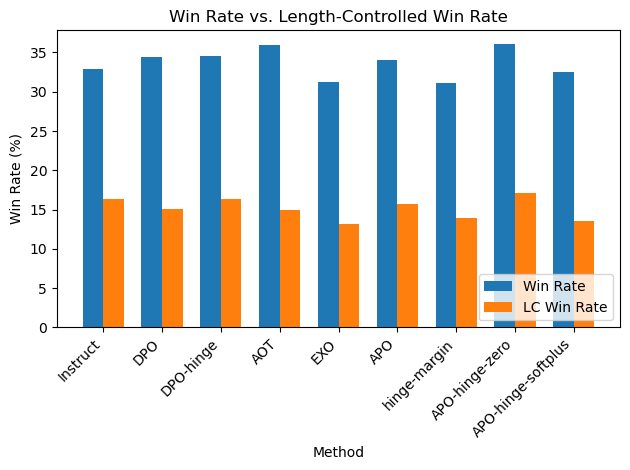

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

methods = ['Instruct', 'DPO', 'DPO-hinge', 'AOT', 'EXO','APO' ,'hinge-margin', 'APO-hinge-zero','APO-hinge-softplus']
win_rates = np.array([32.92, 34.41, 34.60, 35.92, 31.22, 34.02, 31.11, 36.02, 34.10])
std = [1.65,1.67,1.67,1.73,1.65,1.7,1.66,1.69,1.69]
lc_rates = np.array([16.39, 15.02, 16.37, 14.96, 13.15, 15.68, 13.91, 17.07, 12.67])


x = np.arange(len(methods))
width = 0.35

plt.figure()
plt.bar(x - width/2, win_rates, width, label='Win Rate',  capsize=5)
plt.bar(x + width/2, lc_rates, width, label='LC Win Rate', capsize=5)
plt.xticks(x, methods, rotation = 45, ha='right')
plt.xlabel('Method')
plt.ylabel('Win Rate (%)')
plt.title('Win Rate vs. Length-Controlled Win Rate')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()
